In [1]:
%matplotlib inline

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

##  Calculate $V_{\rm max}$ percentile for host halos

In [7]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')
host_halos = halocat.halo_table[halocat.halo_table['halo_upid']==-1]

from halotools.utils import sliding_conditional_percentile
x = host_halos['halo_mvir']
y = host_halos['halo_vmax']
nwin = 301
host_halos['vmax_percentile'] = sliding_conditional_percentile(x, y, nwin)

## Calculate median luminosity for every galaxy

In [8]:
from halotools.empirical_models import Cacciato09Cens
model = Cacciato09Cens()
host_halos['median_luminosity'] = model.median_prim_galprop(
        prim_haloprop=host_halos['halo_mvir'])

##  Generate Monte Carlo log-normal luminosity realization using CAM

In [9]:
from scipy.stats import norm

host_halos['luminosity'] = 10**norm.isf(1-host_halos['vmax_percentile'], 
                                   loc=np.log10(host_halos['median_luminosity']),
                                       scale=0.2)

### Plot the results

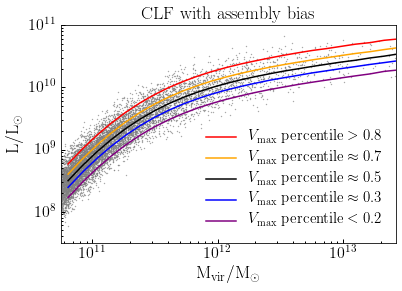

In [10]:
xmin, xmax = 10**10.75, 10**13.5

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.scatter(host_halos['halo_mvir'][::100], 
              host_halos['luminosity'][::100], s=0.1, color='gray', label='')

from scipy.stats import binned_statistic
log_mass_bins = np.linspace(np.log10(xmin), np.log10(xmax), 25)
mass_mids = 10**(0.5*(log_mass_bins[:-1] + log_mass_bins[1:]))

median_lum, __, __ = binned_statistic(
    host_halos['halo_mvir'], host_halos['luminosity'], bins=10**log_mass_bins, 
    statistic='median')

high_vmax_mask = host_halos['vmax_percentile'] > 0.8
median_lum_high_vmax, __, __ = binned_statistic(
    host_halos['halo_mvir'][high_vmax_mask], host_halos['luminosity'][high_vmax_mask], 
    bins=10**log_mass_bins, statistic='median')

mid_high_vmax_mask = host_halos['vmax_percentile'] < 0.8
mid_high_vmax_mask *= host_halos['vmax_percentile'] > 0.6
median_lum_mid_high_vmax, __, __ = binned_statistic(
    host_halos['halo_mvir'][mid_high_vmax_mask], host_halos['luminosity'][mid_high_vmax_mask], 
    bins=10**log_mass_bins, statistic='median')

mid_low_vmax_mask = host_halos['vmax_percentile'] < 0.4
mid_low_vmax_mask *= host_halos['vmax_percentile'] > 0.2
median_lum_mid_low_vmax, __, __ = binned_statistic(
    host_halos['halo_mvir'][mid_low_vmax_mask], host_halos['luminosity'][mid_low_vmax_mask], 
    bins=10**log_mass_bins, statistic='median')


low_vmax_mask = host_halos['vmax_percentile'] < 0.2
median_lum_low_vmax, __, __ = binned_statistic(
    host_halos['halo_mvir'][low_vmax_mask], host_halos['luminosity'][low_vmax_mask], 
    bins=10**log_mass_bins, statistic='median')

__=ax.plot(mass_mids, median_lum_high_vmax, color='red', 
          label=r'$V_{\rm max}\ {\rm percentile} > 0.8$')
__=ax.plot(mass_mids, median_lum_mid_high_vmax, color='orange',
          label=r'$V_{\rm max}\ {\rm percentile} \approx 0.7$')
__=ax.plot(mass_mids, median_lum, color='k', 
          label=r'$V_{\rm max}\ {\rm percentile} \approx 0.5$')
__=ax.plot(mass_mids, median_lum_mid_low_vmax, color='blue', 
          label=r'$V_{\rm max}\ {\rm percentile} \approx 0.3$')
__=ax.plot(mass_mids, median_lum_low_vmax, color='purple',
          label=r'$V_{\rm max}\ {\rm percentile} < 0.2$')

xlim = ax.set_xlim(xmin, xmax/1.2)
ylim = ax.set_ylim(10**7.5, 10**11)
legend = ax.legend()

xlabel = ax.set_xlabel(r'${\rm M_{vir}/M_{\odot}}$')
ylabel = ax.set_ylabel(r'${\rm L/L_{\odot}}$')
title = ax.set_title(r'${\rm CLF\ with\ assembly\ bias}$')

figname = 'cam_example_assembias_clf.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')